# Numba Stencil


Operasi stencil https://www.mathworks.com/help/parallel-computing/stencil-operations-on-a-gpu.html biasanya digunakan pada metode finite differences, finite elements, atau metode lain yang memanfaatkan suatu mesh atau grid.

## Persamaan Panas 1D

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \hspace{1em} x \in (0,L), t \in (0, T]
$$

dengan inisial awal $u(x,0) = I_0(x)$ dan syarat batas $u(0,t) = 0$ dan $u(L,t) = 0$.

Masalah ini dapat kita selesaikan dengan mendiskritisasi ruang dan waktunya (disebut juga dengan **metode finite difference**):

* **space discretisation:** $x_i = i\Delta x, i = 0, 1, \cdots, N_x$.
* **time discretisation:** $t_n = n\Delta t, t = 0, 1, \cdots, N_t$

dengan menggunakan **Central Time Central Space (CTCS)** atau dikenal sebagai metode **Crank-Nicolson 1D**

$$
\frac{w_i^{n+1} - w_i^n}{\Delta t} = \alpha \frac{w_{i+1}^n - 2w_i^n + w_{i-1}^n}{\Delta x^2}
$$

sehingga memebentuk

$$
w_i^{n+1} = w_i^n + F(w_{i+1}^n - 2w_i^n + w_{i-1}^n)
$$

dimana $F = \alpha \frac{\Delta t}{\Delta x^2}$.


![](../images/Heat1D.jpg)

Di dalam perhitungan grid terdapat $w_{i-1}, w_i, w_{i+1}$ yang disebut sebagai **3-titik stencil**.

![](../images/Stencil1D.jpg)

**Implementasi**

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt

In [32]:
Nx = 500
Nt = 10_000
T = 100.
L = 100.

dx = L/Nx
dt = T/Nt
alpha = 1.0
F = alpha * dt/dx*dx

x = np.linspace(0, L, Nx+1)

# nilai awal: sin(2*pi*x) dimana 50 <= x <= 60
temp_awal = np.zeros(Nx+1)
temp_awal[Nx//2:Nx//2+Nx//10] = np.sin(2.0 * np.pi * (x[Nx//2:Nx//2+Nx//10] - x[Nx//2]) / (L/5) )

In [33]:
@numba.stencil
def Crank_Nicolson(x, F):
    return x[0] + F * (x[1] - 2.0 * x[0] + x[-1])

In [34]:
@numba.njit
def simulasi(x, F, Nt):
    for i in range(Nt):
        x = Crank_Nicolson(x, F)
    
    return x

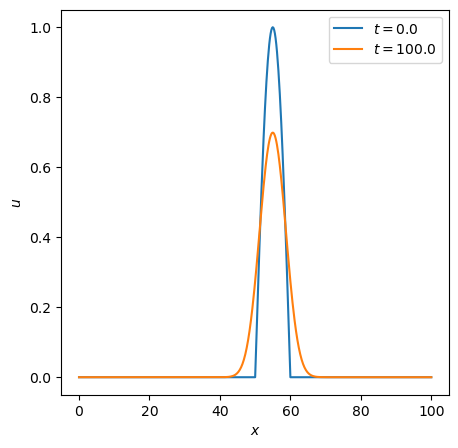

In [35]:
temp_simulasi = simulasi(temp_awal, F, Nt)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')

ax.plot(x, temp_awal, label='$t = 0.0$')
ax.plot(x, temp_simulasi, label=f'$t = {T}$')

ax.legend()
plt.show()

## Analisa Performa

**Python vs NumPy vs Numba**

In [37]:
%time simulasi(temp_awal, F, Nt);

CPU times: user 7.93 ms, sys: 121 µs, total: 8.05 ms
Wall time: 8.02 ms


array([0.00000000e+00, 3.87701413e-65, 1.25213409e-64, 3.64827742e-64,
       1.04792714e-63, 2.99652776e-63, 8.53976926e-63, 2.42588815e-62,
       6.86904081e-62, 1.93874084e-61, 5.45429548e-61, 1.52950047e-60,
       4.27513080e-60, 1.19106322e-59, 3.30752096e-59, 9.15481433e-59,
       2.52564538e-58, 6.94492948e-58, 1.90341146e-57, 5.19952436e-57,
       1.41565480e-56, 3.84158668e-56, 1.03901096e-55, 2.80080279e-55,
       7.52479246e-55, 2.01489672e-54, 5.37717273e-54, 1.43019342e-53,
       3.79115731e-53, 1.00157094e-52, 2.63706687e-52, 6.91969111e-52,
       1.80956851e-51, 4.71609691e-51, 1.22491620e-50, 3.17060833e-50,
       8.17876941e-50, 2.10251478e-49, 5.38632368e-49, 1.37513299e-48,
       3.49858452e-48, 8.87017129e-48, 2.24109441e-47, 5.64252302e-47,
       1.41568979e-46, 3.53949214e-46, 8.81837194e-46, 2.18930862e-45,
       5.41618112e-45, 1.33519126e-44, 3.27985302e-44, 8.02827732e-44,
       1.95814076e-43, 4.75899752e-43, 1.15248039e-42, 2.78095883e-42,
      